52 week high backtester

In [1]:
!pip install yfinance

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached peewee-3.18.3.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached curl_cffi-0.13.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-macosx_11_0_arm64.whl (3.0 MB)
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/p

In [2]:
#imported neccessary libraries, since only price data was needed I chose to use Yahoo Finance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
# Get ticker universe from GitHub, used raw url if someone wants to run locally
ticker_universe = pd.read_csv("https://raw.githubusercontent.com/EarthWolves/SFIC-Potfolio-Strategy-Backtests/refs/heads/main/stock_universe.csv")

tickers = ticker_universe["Symbol"].tolist()
tickers = [t.replace('.', '-') for t in tickers]

## Base Test
We first begin with a basic analysis: a monthly rebalancing using the orgininal model proposed in the paper, explored on a ticker universe of the top 500 companies by volume with a portfolio of $10000 (1% of SFiC's current portfolio).

In [4]:
# download prices for last 25 years as this is the period backtest will cover
#prices are recorded weekly since the model uses a 52-week high basis
prices = yf.download(tickers, start="2000-01-01", interval="1wk")

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/3608829165.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start="2000-01-01", interval="1wk")
[**********************54%*                      ]  272 of 503 completedHTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
[*********************100%***********************]  503 of 503 completed

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


In [57]:
prices = prices.dropna(axis=1, how='all') # Drop columns with all NaNs
 
# calculate 52-week rolling high, shifted by 1 to avoid lookahead bias
# min_periods = 2 to ensure at least some data is present, but that a stock does not get selected on its first week of trading
rolling_high = prices.shift(1).rolling(window=52, min_periods=2).max()

# calculate distance to 52-week high to determine which stocks are closest and should therefore be selected
dist_to_high = (rolling_high - prices) / rolling_high

In [132]:
#calculate distance to high on a monthly basis, as we rebalance monthly
monthly_dist_to_high = dist_to_high.resample('M').last()
monthly_portfolios = {}

# For each month, select the 10 stocks closest to their 52-week high
for date, row in monthly_dist_to_high.iterrows():
    top_tickers = row.dropna().nsmallest(10).index.tolist()
    monthly_portfolios[date] = [tup[1] for tup in top_tickers] # to get rid of multiindex

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1355636752.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dist_to_high = dist_to_high.resample('M').last()


In [133]:
close_prices = prices['Close'] # Focus on close prices for return calculations
returns = close_prices.pct_change().shift(-1) # Daily returns, shifted to represent next month's return

/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1608390921.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().shift(-1) # Daily returns, shifted to represent next month's return


In [ ]:
portfolio_value = [10000.00]  # starting with $10,000 allocation
dates = sorted(monthly_portfolios.keys())

# calculate portfolio value over time, rebalancing monthly and assigning equal weight to each selected stock
for i in range(len(dates) - 1):
    date = dates[i]
    next_date = dates[i+1]
    
    tickers = monthly_portfolios[date]
    
    try:
        monthly_ret = returns.loc[date, tickers]
        monthly_ret = monthly_ret.dropna()
        
        if len(monthly_ret) > 0:
            avg_return = monthly_ret.mean()
        else:
            avg_return = 0

        new_value = portfolio_value[-1] * (1 + avg_return)
        portfolio_value.append(new_value)

    except KeyError:
        portfolio_value.append(portfolio_value[-1])


<Axes: title={'center': 'Backtested Portfolio Value for 52-week High Momentum Strategy'}, xlabel='Date', ylabel='Portfolio Value ($)'>

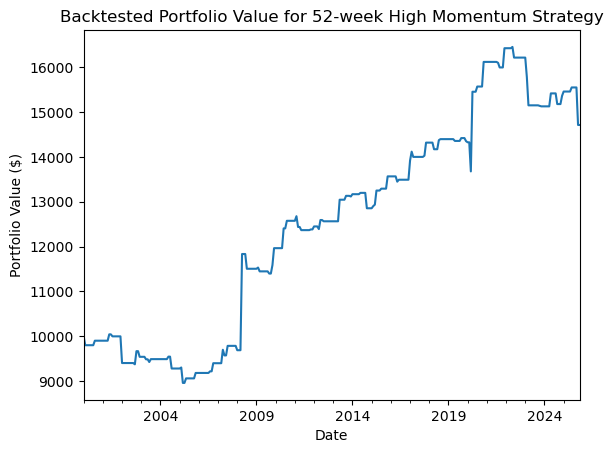

In [135]:
# generate chart of portfolio value over timea
portfolio_series = pd.Series(portfolio_value, index=dates)
portfolio_series.plot(title='Backtested Portfolio Value for 52-week High Momentum Strategy', ylabel='Portfolio Value ($)', xlabel='Date')

In [136]:
sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-11-12", interval="1wk")["Close"]
sp500.name = "S&P 500"

portfolio_series_norm = portfolio_series / portfolio_series.iloc[0]
sp500_norm = sp500 / sp500.iloc[0]

aligned = pd.concat([portfolio_series_norm, sp500_norm], axis=1).dropna()


/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1314142382.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-11-12", interval="1wk")["Close"]
[*********************100%***********************]  1 of 1 completed


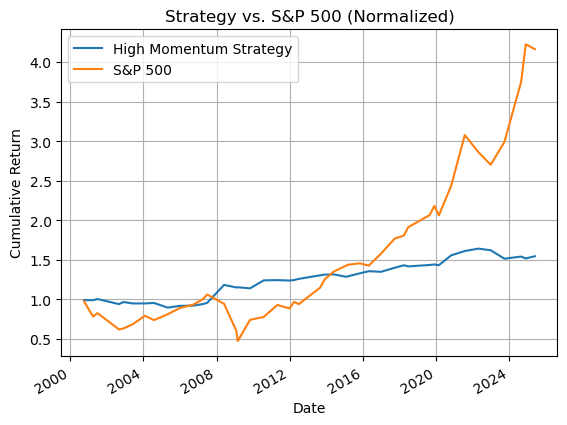

In [137]:
aligned.plot(title="Strategy vs. S&P 500 (Normalized)", ylabel="Cumulative Return", xlabel="Date")
plt.legend(["High Momentum Strategy", "S&P 500"])
plt.grid(True)
plt.show()

In [139]:
# calculate and compare performance metrics for both portfolio and S&P 500

#make combined dataframe for easier calculations
combined = pd.concat([portfolio_series_norm, sp500_norm], axis=1).dropna()

#CAGR
n_years = (combined.index[-1] - combined.index[0]).days / 365.25
cagr_portfolio = (portfolio_series.iloc[-1] / portfolio_series.iloc[0])**(1/n_years) - 1
cagr_sp500 = (sp500.squeeze().iloc[-1] / sp500.squeeze().iloc[0])**(1/n_years) - 1

print(f"CAGR - Portfolio: {cagr_portfolio:.2%}, S&P 500: {cagr_sp500:.2%}")

# Sharpe Ratio
risk_free_rate = 0.02  # assumed annual risk-free rate of 2%
portfolio_returns = portfolio_series_norm.pct_change().dropna()
sharpe_ratio = ((portfolio_returns.mean() - risk_free_rate/52) / portfolio_returns.std()) * (52 ** 0.5)

sp500_returns = sp500_norm.squeeze().pct_change().dropna()
sharpe_sp500 = ((sp500_returns.mean() - risk_free_rate/52) / sp500_returns.std()) * (52 ** 0.5)

print(f"Sharpe Ratio - Portfolio: {sharpe_ratio:.2f}, S&P 500: {sharpe_sp500:.2f}")

# Maximum Drawdown
def max_drawdown(series):
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    return drawdown.min()
max_dd_portfolio = max_drawdown(portfolio_series)
max_dd_sp500 = max_drawdown(sp500.squeeze())

print(f"Maximum Drawdown - Portfolio: {max_dd_portfolio:.2%}, S&P 500: {max_dd_sp500:.2%}")


CAGR - Portfolio: 1.58%, S&P 500: 6.52%
Sharpe Ratio - Portfolio: 0.41, S&P 500: 0.32
Maximum Drawdown - Portfolio: -10.78%, S&P 500: -56.24%


## Refinement

we now test alternative models to see what maximizes returns. we begin with exploring different time frames.

In [109]:
#add sharpe ration, max drawdown, and CAGR
#fine grain time period 
#snp 500 -
#multiple plots for different rebalancing periods
#explain model!!!

In [183]:
def change_portfolio_time(time_interval):
    # Function to create portfolio based on specified time interval
    resampled_dist_to_high = dist_to_high.resample(time_interval).last()
    resampled_portfolios = {}

    for date, row in resampled_dist_to_high.iterrows():
        top_tickers = row.dropna().nsmallest(10).index.tolist()
        resampled_portfolios[date] = [tup[1] for tup in top_tickers]

    portfolio_value = [10000.00]  
    dates = sorted(resampled_portfolios.keys())

    for i in range(len(dates) - 1):
        date = dates[i]
        next_date = dates[i+1]
        
        tickers = resampled_portfolios[date]
        
        try:
            resampled_ret = returns.loc[date, tickers]
            resampled_ret = resampled_ret.dropna()
            
            if len(resampled_ret) > 0:
                avg_return = resampled_ret.mean()
            else:
                avg_return = 0

            new_value = portfolio_value[-1] * (1 + avg_return)
            portfolio_value.append(new_value)
        
        except KeyError:
            portfolio_value.append(portfolio_value[-1])

    portfolio_series = pd.Series(portfolio_value, index=dates)
    
    return portfolio_series


/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval).last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval).last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval).last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval)

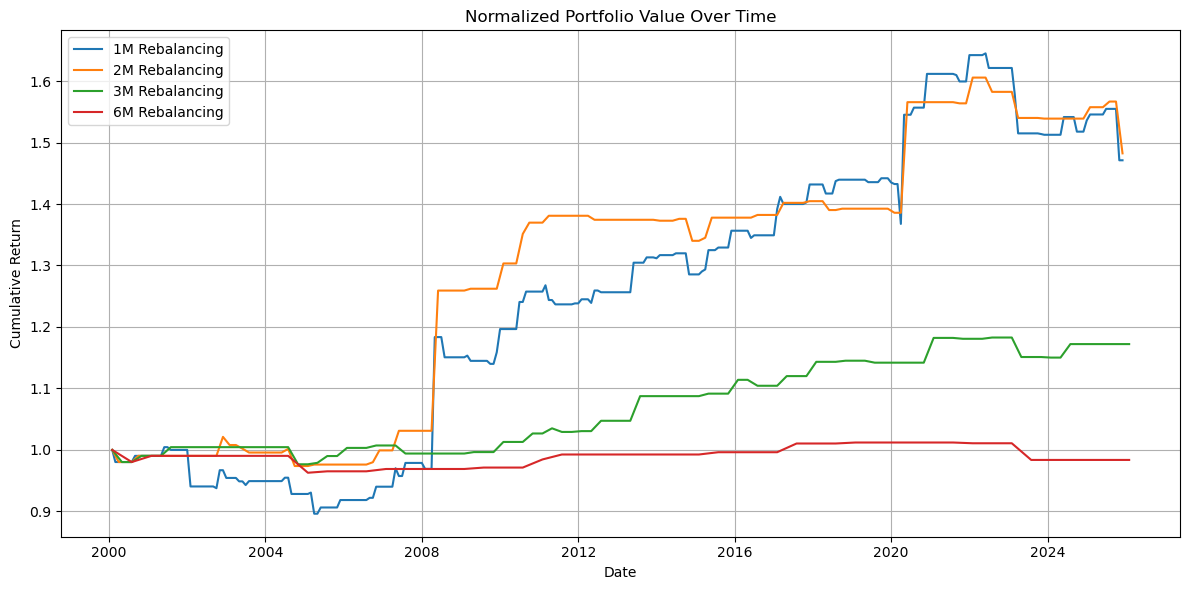

In [184]:
# Generate portfolios for different rebalancing intervals and plot

granularities = ['1M', '2M', '3M', '6M']
series_dict = {g: change_portfolio_time(g) for g in granularities}

plt.figure(figsize=(12, 6))
for g, s in series_dict.items():
    normalized = s / s.iloc[0]
    plt.plot(normalized, label=f'{g} Rebalancing')
    
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

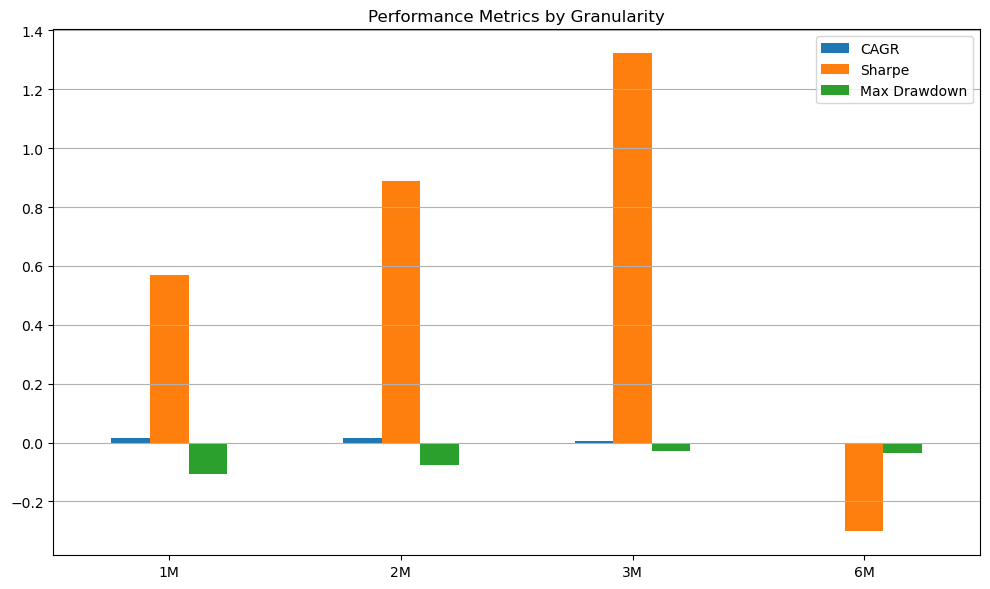

In [185]:
# Calculate and display performance metrics for each granularity

def compute_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series.iloc[-1] / series.iloc[0] - 1
    num_years = (series.index[-1] - series.index[0]).days / 365.25
    cagr = (series.iloc[-1] / series.iloc[0])**(1 / num_years) - 1
    sharpe = (returns.mean() / returns.std()) * np.sqrt(52)  # assume weekly frequency
    running_max = series.cummax()
    drawdown = (series / running_max) - 1
    max_dd = drawdown.min()
    return {'CAGR': cagr, 'Sharpe': sharpe, 'Max Drawdown': max_dd}

metrics = {g: compute_metrics(s) for g, s in series_dict.items()}
metrics_df = pd.DataFrame(metrics).T

# Bar plot
metrics_df.plot(kind='bar', figsize=(10, 6), title='Performance Metrics by Granularity')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [186]:
sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-11-12", interval="1wk")["Close"]
sp500.name = "S&P 500"

portfolio_series_norm = change_portfolio_time("2M") / change_portfolio_time("2M").iloc[0]
sp500_norm = sp500 / sp500.iloc[0]

aligned = pd.concat([portfolio_series_norm, sp500_norm], axis=1).dropna()


/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1780660158.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-11-12", interval="1wk")["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval).last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/1997585067.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample(time_interval).last()


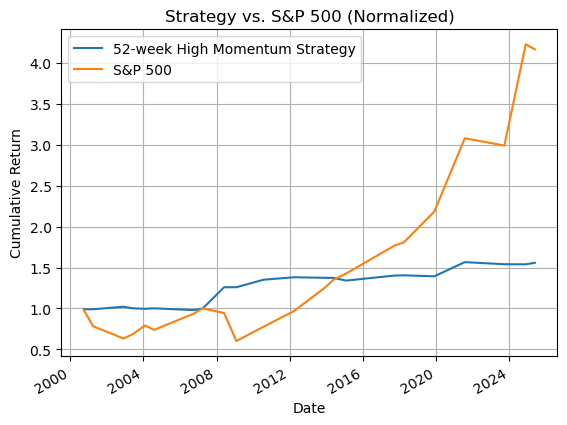

In [187]:
aligned.plot(title="Strategy vs. S&P 500 (Normalized)", ylabel="Cumulative Return", xlabel="Date")
plt.legend(["52-week High Momentum Strategy", "S&P 500"])
plt.grid(True)
plt.show()

In [188]:
# calculate and compare performance metrics for both portfolio and S&P 500

#make combined dataframe for easier calculations
combined = pd.concat([portfolio_series_norm, sp500_norm], axis=1).dropna()

#CAGR
n_years = (combined.index[-1] - combined.index[0]).days / 365.25
cagr_portfolio = (portfolio_series.iloc[-1] / portfolio_series.iloc[0])**(1/n_years) - 1
cagr_sp500 = (sp500.squeeze().iloc[-1] / sp500.squeeze().iloc[0])**(1/n_years) - 1

print(f"CAGR - Portfolio: {cagr_portfolio:.2%}, S&P 500: {cagr_sp500:.2%}")

# Sharpe Ratio
risk_free_rate = 0.02  # assumed annual risk-free rate of 2%
portfolio_returns = portfolio_series_norm.pct_change().dropna()
sharpe_ratio = ((portfolio_returns.mean() - risk_free_rate/52) / portfolio_returns.std()) * (52 ** 0.5)

sp500_returns = sp500_norm.squeeze().pct_change().dropna()
sharpe_sp500 = ((sp500_returns.mean() - risk_free_rate/52) / sp500_returns.std()) * (52 ** 0.5)

print(f"Sharpe Ratio - Portfolio: {sharpe_ratio:.2f}, S&P 500: {sharpe_sp500:.2f}")

# Maximum Drawdown
def max_drawdown(series):
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    return drawdown.min()
max_dd_portfolio = max_drawdown(portfolio_series)
max_dd_sp500 = max_drawdown(sp500.squeeze())

print(f"Maximum Drawdown - Portfolio: {max_dd_portfolio:.2%}, S&P 500: {max_dd_sp500:.2%}")


CAGR - Portfolio: 1.61%, S&P 500: 6.52%
Sharpe Ratio - Portfolio: 0.77, S&P 500: 0.32
Maximum Drawdown - Portfolio: -7.68%, S&P 500: -56.24%


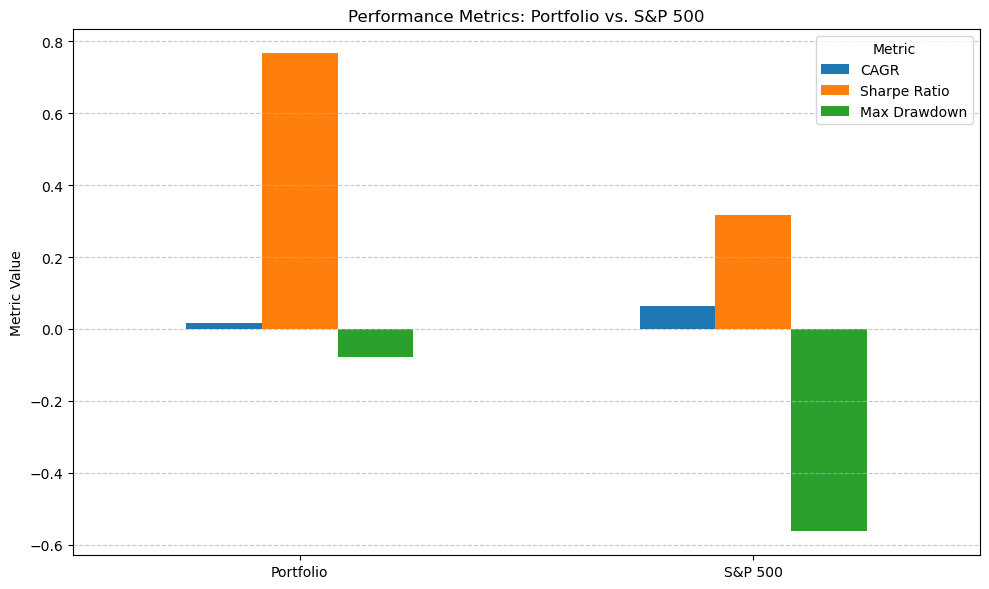

In [189]:
# plot comparison bar chart of metrics

metrics_data = {
    "Portfolio": {
        "CAGR": cagr_portfolio,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_dd_portfolio
    },
    "S&P 500": {
        "CAGR": cagr_sp500,
        "Sharpe Ratio": sharpe_sp500,
        "Max Drawdown": max_dd_sp500
    }
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df = metrics_df.T

fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=ax)

plt.title("Performance Metrics: Portfolio vs. S&P 500")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


Next, we explore different amounts of stocks selected.

In [ ]:
def change_portfolio_size(stock_count):
    # Function to create portfolio based on specified stock count
    resampled_dist_to_high = dist_to_high.resample("2M").last()
    resampled_portfolios = {}

    for date, row in resampled_dist_to_high.iterrows():
        top_tickers = row.dropna().nsmallest(stock_count).index.tolist()
        resampled_portfolios[date] = [tup[1] for tup in top_tickers]

    portfolio_value = [10000.00]  
    dates = sorted(resampled_portfolios.keys())

    for i in range(len(dates) - 1):
        date = dates[i]
        next_date = dates[i+1]
        
        tickers = resampled_portfolios[date]
        
        try:
            resampled_ret = returns.loc[date, tickers]
            resampled_ret = resampled_ret.dropna()
            
            if len(resampled_ret) > 0:
                avg_return = resampled_ret.mean()
            else:
                avg_return = 0

            new_value = portfolio_value[-1] * (1 + avg_return)
            portfolio_value.append(new_value)
        
        except KeyError:
            portfolio_value.append(portfolio_value[-1])

    portfolio_series = pd.Series(portfolio_value, index=dates)
    
    return portfolio_series


/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/2683568161.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample("2M").last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/2683568161.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample("2M").last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/2683568161.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample("2M").last()
/var/folders/8_/9yt14hp57r3d9zbtwvs8r6rh0000gn/T/ipykernel_21626/2683568161.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_dist_to_high = dist_to_high.resample("2M").last()
/var/folders/8_/9yt14hp57r3d

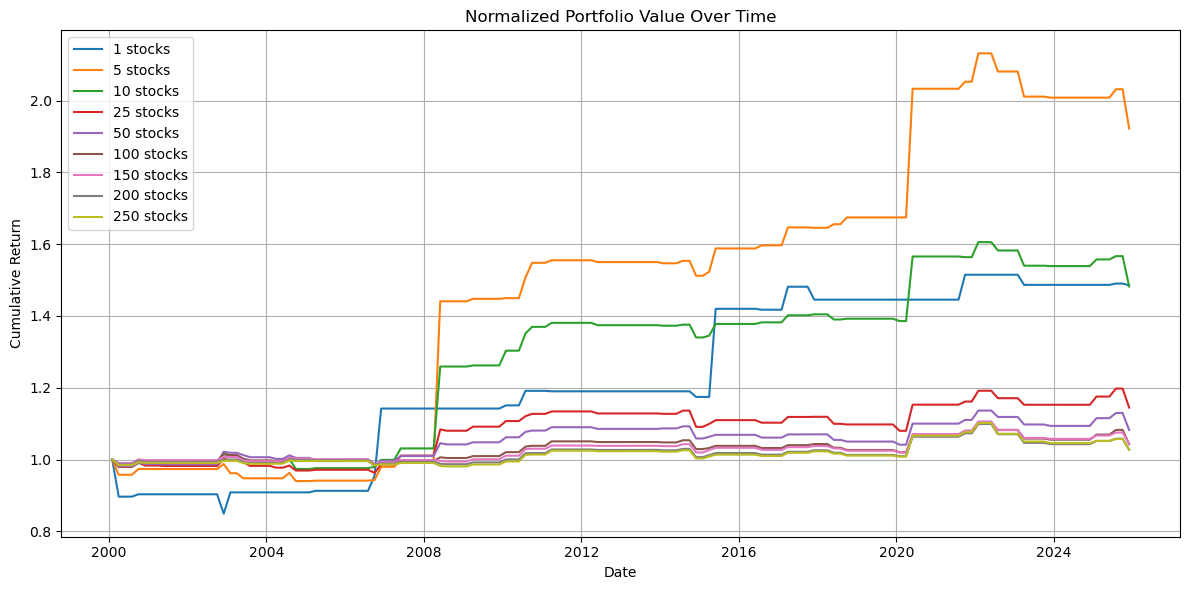

In [194]:
# Generate portfolios for different rebalancing intervals and plot

sizes = [1, 5, 10, 25, 50, 100, 150, 200, 250]
series_dict = {i: change_portfolio_size(i) for i in sizes}

plt.figure(figsize=(12, 6))
for n, s in series_dict.items():
    normalized = s / s.iloc[0]
    plt.plot(normalized, label=f'{n} stocks')
    
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [195]:
# compute performance metrics for each portfolio

cagr_dict = {}
sharpe_dict = {}
maxdd_dict = {}

risk_free_rate = 0.02  # Annual risk-free rate

# Compute metrics for each portfolio
for size, series in series_dict.items():
    normalized = series / series.iloc[0]
    returns = normalized.pct_change().dropna()
    
    # CAGR
    n_years = (series.index[-1] - series.index[0]).days / 365.25
    cagr = (series.iloc[-1] / series.iloc[0]) ** (1/n_years) - 1
    cagr_dict[size] = cagr

    # Sharpe Ratio
    sharpe = ((returns.mean() - risk_free_rate/52) / returns.std()) * (52 ** 0.5)
    sharpe_dict[size] = sharpe

    # Max Drawdown
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    maxdd = drawdown.min()
    maxdd_dict[size] = maxdd


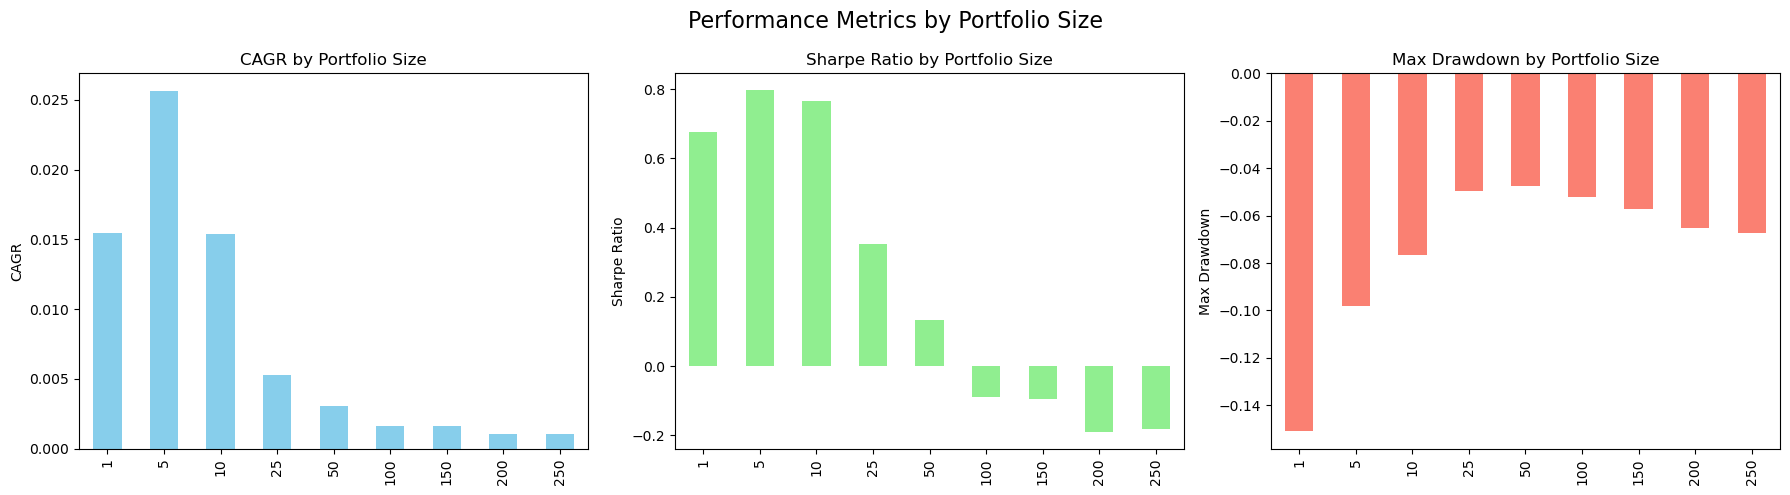

In [196]:
# Plot metrics in a bar chart
metrics_df = pd.DataFrame({
    'CAGR': pd.Series(cagr_dict),
    'Sharpe Ratio': pd.Series(sharpe_dict),
    'Max Drawdown': pd.Series(maxdd_dict)
}).sort_index()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_df['CAGR'].plot(kind='bar', ax=axes[0], color='skyblue', title='CAGR by Portfolio Size')
axes[0].set_ylabel("CAGR")

metrics_df['Sharpe Ratio'].plot(kind='bar', ax=axes[1], color='lightgreen', title='Sharpe Ratio by Portfolio Size')
axes[1].set_ylabel("Sharpe Ratio")

metrics_df['Max Drawdown'].plot(kind='bar', ax=axes[2], color='salmon', title='Max Drawdown by Portfolio Size')
axes[2].set_ylabel("Max Drawdown")

plt.suptitle("Performance Metrics by Portfolio Size", fontsize=16)
plt.tight_layout()
plt.show()
